### Model Testing 
Author: Anne Tumlin

Date: 04/10/25 

Let's compare this problem across various types of models and evaluate the performance. 

In [2]:
import os
import subprocess
import time
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, input_file_name, expr, sum as spark_sum, avg, count

spark = SparkSession.builder \
    .appName("app_name") \
    .getOrCreate()

Here we are going to load in our saved parquet file of the final dataset we are using for the prediction task. If you do not have this saved, go to Mileston3 and run the notebook to aquire this dataset. 

*Important note: make sure to change to your bucket name here.* 

In [5]:
# Set the bucket name (user can change this line)
bucket_name = "ds5460-tumlinam-fp-bucket"

data_path = f"gs://{bucket_name}/final_datasets/combined_features_df/"

In [24]:
df = spark.read.parquet(data_path)
df.show(5)

+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+
|            filename|        total_cost|            avg_pd|       pd_per_load|     reactive_ratio|             std_pd|  load_variability|          pd_range|        load_range|            max_pd|  load_concentration|        load_skew|  generation_margin| load_to_gen_ratio|
+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+
|gs://ds5460-tumli...| 457017.6915453811|0.6337165224374126|0.6337165224374126|0.25578066583740294| 0.3907887552662506| 0.616661774515822| 2.895855111560307| 2.895855111560307| 2

### Simple Model Comparisons 

Let's set up the code to test various simple models. 

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col
import time

In [13]:
feature_cols = [c for c in df.columns if c != "filename" and c != "total_cost"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df).select("features", col("total_cost").alias("label"))

In [14]:
train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=42)

In [15]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Models to test
models = [
    (LinearRegression(), "Linear Regression"),
    (DecisionTreeRegressor(), "Decision Tree"),
    (RandomForestRegressor(), "Random Forest"),
    (GBTRegressor(), "Gradient Boosted Trees")
]

In [16]:
def train_and_evaluate_model(regressor, name):
    start_time = time.time()
    
    # Train the model
    model = regressor.fit(train_data)
    
    # Make predictions
    predictions = model.transform(test_data)
    
    # Evaluate metrics
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    mae = evaluator.setMetricName("mae").evaluate(predictions)
    r2 = evaluator.setMetricName("r2").evaluate(predictions)
    
    end_time = time.time()
    train_time = end_time - start_time

    return (name, rmse, mae, r2, train_time)

In [ ]:
results = [train_and_evaluate_model(m, n) for m, n in models]

columns = ["Model", "RMSE", "MAE", "R2", "TrainingTime"]
results_df = spark.createDataFrame(results, columns)

results_df.show(truncate=False)

+----------------------+------------------+------------------+------------------+-----------------+
|Model                 |RMSE              |MAE               |R2                |TrainingTime     |
+----------------------+------------------+------------------+------------------+-----------------+
|Linear Regression     |287.77412801849573|225.16385899537582|0.998229821839609 |101.727698802948 |
|Decision Tree         |699.8999269546724 |429.013258415274  |0.9895290669824389|77.06891965866089|
|Random Forest         |593.2220765597973 |382.12375761585423|0.9924777442561689|78.0661551952362 |
|Gradient Boosted Trees|464.04424844225764|344.3683654447017 |0.995397092223656 |71.09090065956116|
+----------------------+------------------+------------------+------------------+-----------------+



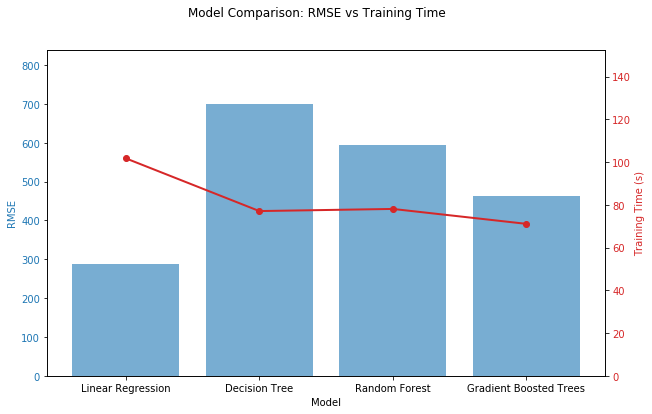

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "Gradient Boosted Trees"],
    "RMSE": [287.77412801849573, 699.8999269546724, 593.2220765597973, 464.04424844225764],
    "MAE": [225.16385899537582, 429.013258415274, 382.12375761585423, 344.3683654447017],
    "R2": [0.998229821839609, 0.9895290669824389, 0.9924777442561689, 0.995397092223656],
    "TrainingTime": [101.727698802948, 77.06891965866089, 78.0661551952362, 71.09090065956116]
}

df_plot = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for RMSE
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color=color)
ax1.bar(df_plot["Model"], df_plot["RMSE"], color=color, alpha=0.6, label="RMSE")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, max(df_plot["RMSE"]) * 1.2)

# Line plot for Training Time on second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(df_plot["Model"], df_plot["TrainingTime"], color=color, marker='o', linewidth=2, label="Training Time")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, max(df_plot["TrainingTime"]) * 1.5)

# Title and layout
fig.suptitle("Model Comparison: RMSE vs Training Time")
plt.show()


Let's check if scaling features has any impact.

In [25]:
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
assembled_df = assembler.transform(df).select("raw_features", col("total_cost").alias("label"))

scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df).select("features", "label")

train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
results = [train_and_evaluate_model(m, n) for m, n in models]

columns = ["Model", "RMSE", "MAE", "R2", "TrainingTime"]
results_df = spark.createDataFrame(results, columns)

results_df.show(truncate=False)

+----------------------+------------------+------------------+------------------+------------------+
|Model                 |RMSE              |MAE               |R2                |TrainingTime      |
+----------------------+------------------+------------------+------------------+------------------+
|Linear Regression     |287.77421453655427|225.163897829646  |0.9982298207752158|109.97668480873108|
|Decision Tree         |719.5715519901579 |429.56542528141347|0.9889321960992391|84.46722173690796 |
|Random Forest         |593.2220765597973 |382.12375761585423|0.9924777442561689|99.43381118774414 |
|Gradient Boosted Trees|467.1145427704447 |345.5068144724461 |0.9953359815257938|99.42195463180542 |
+----------------------+------------------+------------------+------------------+------------------+



### More Complex Models 

Now that we have our results for the simple models, let's see what tuning we can do to improve results. GBT had the lowest training time and second best RMSE. Therefore, let's see if we can improve the outcome via hyperparameter tuning. 

In [27]:
--jars=gs://your-bucket/jars/xgboost4j-spark_2.12-1.7.6.jar,gs://ds5460-tumlinam-fp-bucket/jars/xgboost4j_2.12-1.7.6.jar


ModuleNotFoundError: No module named 'xgboost'